# 非监督式分类，聚类分析+降维

In [5]:
import os
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA as ICA, NMF
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from load_data import read_Decoding_csv, load_neural_npz

In [ ]:
# 定义无监督分析类
class UnsupervisedNeuralAnalysis:
    def __init__(self):
        self.scaler = StandardScaler()
        self.results = {}
        
    def extract_neural_features(self, ts, dff, tgt_dict, window_size=None):
        """提取神经活动特征，不使用刺激标签；提取特征的方法有很多，这里随便做了一些。"""
        all_features = []
        time_segments = []
        true_labels = []  # 仅用于后续评估，不用于训练
        
        # 定义刺激类型映射（仅用于评估）
        stim_type_mapping = {
            'drifting_gratings': 0,
            'static_gratings': 1,
            'natural_scenes': 2,
            'natural_movie': 3
        }
        
        for stim_key, stim_df in tgt_dict.items():
            if 'drifting_gratings' in stim_key:
                stim_type = 'drifting_gratings'
            elif 'static_gratings' in stim_key:
                stim_type = 'static_gratings'
            elif 'natural_scenes' in stim_key:
                stim_type = 'natural_scenes'
            elif 'natural_movie' in stim_key:
                stim_type = 'natural_movie'
            else:
                continue
            
            for _, row in stim_df.iterrows():
                start_time = int(row['start'])
                end_time = int(row['end'])
                
                if start_time >= 0 and end_time < dff.shape[1] and start_time < end_time:
                    # 提取多种特征
                    segment_data = dff[:, start_time:end_time]
                    
                    # 特征1: 平均活动
                    mean_activity = np.mean(segment_data, axis=1)
                    
                    # 特征2: 最大活动
                    max_activity = np.max(segment_data, axis=1)
                    
                    # 特征3: 活动变异性
                    std_activity = np.std(segment_data, axis=1)
                    
                    # 特征4: 峰值数量
                    peak_counts = np.array([np.sum(np.diff(seg) > 0.1) for seg in segment_data])
                    
                    # 组合特征
                    if window_size is None:
                        features = np.concatenate([mean_activity, max_activity, std_activity, peak_counts])
                    else:
                        # 使用滑动窗口（没写）
                        features = mean_activity
                    
                    all_features.append(features)
                    time_segments.append((start_time, end_time))
                    true_labels.append(stim_type_mapping[stim_type])
        
        return np.array(all_features), np.array(true_labels), time_segments
    
    def dimensionality_reduction(self, X, method='pca', n_components=10):
        """降维分析"""
        if method == 'pca':
            reducer = PCA(n_components=n_components)
        elif method == 'ica':
            reducer = ICA(n_components=n_components, random_state=42)
        elif method == 'tsne':
            reducer = TSNE(n_components=min(n_components, 3), random_state=42)
        elif method == 'umap':
            try:
                import umap
                reducer = umap.UMAP(n_components=min(n_components, 3), random_state=42)
            except ImportError:
                print("UMAP not available, using PCA instead")
                reducer = PCA(n_components=n_components)
        
        X_reduced = reducer.fit_transform(X)
        return X_reduced, reducer
    
    def cluster_analysis(self, X, method='kmeans', n_clusters_range=range(2, 8)):
        """多种聚类方法分析；可以将传参修改成methods = ['kmeans', 'gmm', 'spectral', 'dbscan']，以便找出最优聚类"""
        clustering_results = {}
        
        # 如果method是字符串，转换为列表
        if isinstance(method, str):
            methods = [method]
        else:
            methods = method
        
        for method_name in methods:
            method_results = {}
            for n_clusters in n_clusters_range:
                try:
                    if method_name == 'kmeans':
                        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                    elif method_name == 'gmm':
                        clusterer = GaussianMixture(n_components=n_clusters, random_state=42)
                    elif method_name == 'spectral':
                        clusterer = SpectralClustering(n_clusters=n_clusters, random_state=42)
                    elif method_name == 'dbscan':
                        clusterer = DBSCAN(eps=0.5, min_samples=5)
                        n_clusters = 'auto'
                    
                    labels = clusterer.fit_predict(X)
                    
                    # 计算聚类质量指标
                    if len(np.unique(labels)) > 1:
                        silhouette = silhouette_score(X, labels)
                    else:
                        silhouette = -1
                    
                    method_results[n_clusters] = {
                        'labels': labels,
                        'silhouette_score': silhouette,
                        'n_clusters_found': len(np.unique(labels)),
                        'clusterer': clusterer
                    }
                    
                except Exception as e:
                    print(f"Error in {method_name} with {n_clusters} clusters: {e}")
            
            clustering_results[method_name] = method_results
        
        return clustering_results
    
    def evaluate_clustering(self, predicted_labels, true_labels):
        """评估聚类结果与真实标签的一致性"""
        ari = adjusted_rand_score(true_labels, predicted_labels)
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        return ari, nmi
    
    def analyze_dataset(self, dataset_name, neural_file_path, tgt_dict):
        """分析单个数据集"""
        print(f"\n分析数据集: {dataset_name}")
        
        # 加载神经数据
        for file_name in os.listdir(neural_file_path):
            if file_name.endswith('.npz'):
                ts, dff, all_roi_masks, cids, metadata = load_neural_npz(
                    os.path.join(neural_file_path, file_name))
                break
        
        # 提取特征
        X, true_labels, time_segments = self.extract_neural_features(ts, dff, tgt_dict)
        
        if len(X) == 0:
            return None
        
        # 数据预处理
        X_scaled = self.scaler.fit_transform(X)
        
        # 降维分析
        print("  - 进行降维分析...")
        X_pca, pca_reducer = self.dimensionality_reduction(X_scaled, 'pca', 10)
        # X_tsne, tsne_reducer = self.dimensionality_reduction(X_scaled, 'tsne', 2)
        
        # 聚类分析
        print("  - 进行聚类分析...")
        clustering_results = self.cluster_analysis(X_pca, 'kmeans')
        
        # 寻找最佳聚类
        best_clustering = None
        best_score = -1
        
        for method, method_results in clustering_results.items():
            for n_clusters, result in method_results.items():
                if result['silhouette_score'] > best_score:
                    best_score = result['silhouette_score']
                    best_clustering = {
                        'method': method,
                        'n_clusters': n_clusters,
                        'result': result
                    }
        
        # 评估最佳聚类
        if best_clustering:
            best_labels = best_clustering['result']['labels']
            ari, nmi = self.evaluate_clustering(best_labels, true_labels)
        else:
            ari, nmi = 0, 0
        
        dataset_results = {
            'dataset_name': dataset_name,
            'n_samples': len(X),
            'n_features': X.shape[1],
            'n_neurons': dff.shape[0],
            'X_scaled': X_scaled,
            'X_pca': X_pca,
            # 'X_tsne': X_tsne,
            'true_labels': true_labels,
            'clustering_results': clustering_results,
            'best_clustering': best_clustering,
            'best_silhouette': best_score,
            'ari_score': ari,
            'nmi_score': nmi,
            'pca_explained_variance': pca_reducer.explained_variance_ratio_
        }
        
        self.results[dataset_name] = dataset_results
        
        print(f"  ✓ 完成: 样本数={len(X)}, 最佳轮廓系数={best_score:.3f}, ARI={ari:.3f}, NMI={nmi:.3f}")
        
        return dataset_results

In [7]:
# 运行无监督分析
target_brain_regions = ['VISp', 'VISal', 'VISl']
session_letters = ['A', 'B']
data_root = '../data'

# 创建分析器
analyzer = UnsupervisedNeuralAnalysis()

print("开始无监督神经活动分析...")
print("="*60)

for region in target_brain_regions:
    for session_letter in session_letters:
        dataset_name = f"{region}_{session_letter}"
        
        try:
            # 读取元数据
            tgt_dict, tgt_folder = read_Decoding_csv(data_path=data_root, 
                                                    region_type=region, 
                                                    session_letter=session_letter)
            
            neural_file_path = os.path.join(data_root, tgt_folder)
            
            # 分析数据集
            analyzer.analyze_dataset(dataset_name, neural_file_path, tgt_dict)
            
        except Exception as e:
            print(f"错误: {dataset_name} 分析失败: {e}")

print("\n无监督分析完成！")

开始无监督神经活动分析...
we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_spontaneous.csv

分析数据集: VISp_A
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
  - 进行降维分析...
  - 进行聚类分析...
  ✓ 完成: 样本数=23181, 最佳轮廓系数=0.924, ARI=1.000, NMI=1.000
we have keys in data_dict, including:
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_scenes.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_static_gratings.csv
stimulus_metadata_total.csv

分析数据集: VISp_B
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
  - 进行降维分析...
  - 进行聚类分析...
  ✓ 完成: 样本数=16501, 最佳轮廓系数=0.683, ARI=0.507, NMI=0.700
we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimul

In [8]:
# 可视化和比较分析
def plot_unsupervised_results(analyzer, reduction_methods=['pca'], n_components=2, 
                             figsize_per_dataset=(5, 4), cols_per_row=4):
    """
    可视化无监督分析结果，支持多种降维方法
    
    参数:
        analyzer: UnsupervisedNeuralAnalysis实例
        reduction_methods: 降维方法列表，如['pca', 'tsne', 'umap']
        n_components: 降维后的维数（用于可视化，建议2或3）
        figsize_per_dataset: 每个子图的大小
        cols_per_row: 每行显示多少个子图
    """
    n_datasets = len(analyzer.results)
    n_methods = len(reduction_methods)
    
    if n_datasets == 0:
        print("没有可用的分析结果")
        return
    
    # 计算图形布局
    total_plots = n_datasets * n_methods * 2  # 每个数据集每种方法显示2个图（真实标签+聚类结果）
    n_rows = (total_plots + cols_per_row - 1) // cols_per_row
    
    fig = plt.figure(figsize=(cols_per_row * figsize_per_dataset[0], 
                             n_rows * figsize_per_dataset[1]))
    
    dataset_names = list(analyzer.results.keys())
    plot_idx = 1
    
    # 为每个数据集生成降维数据
    reduction_data = {}
    
    for dataset_name in dataset_names:
        result = analyzer.results[dataset_name]
        reduction_data[dataset_name] = {}
        
        print(f"为数据集 {dataset_name} 计算降维...")
        
        for method in reduction_methods:
            try:
                if method == 'pca':
                    if n_components <= len(result['pca_explained_variance']):
                        # 使用已有的PCA结果
                        X_reduced = result['X_pca'][:, :n_components]
                        explained_var = result['pca_explained_variance'][:n_components]
                        method_title = f"PCA (Var: {np.sum(explained_var):.2f})"
                    else:
                        # 重新计算PCA
                        X_reduced, reducer = analyzer.dimensionality_reduction(
                            result['X_scaled'], 'pca', n_components)
                        explained_var = reducer.explained_variance_ratio_
                        method_title = f"PCA (Var: {np.sum(explained_var):.2f})"
                
                elif method == 'tsne':
                    X_reduced, _ = analyzer.dimensionality_reduction(
                        result['X_scaled'], 'tsne', n_components)
                    method_title = "t-SNE"
                
                elif method == 'umap':
                    try:
                        X_reduced, _ = analyzer.dimensionality_reduction(
                            result['X_scaled'], 'umap', n_components)
                        method_title = "UMAP"
                    except ImportError:
                        print(f"  UMAP不可用，跳过数据集 {dataset_name}")
                        continue
                
                elif method == 'ica':
                    X_reduced, _ = analyzer.dimensionality_reduction(
                        result['X_scaled'], 'ica', n_components)
                    method_title = "ICA"
                
                else:
                    print(f"  未知的降维方法: {method}")
                    continue
                
                reduction_data[dataset_name][method] = {
                    'X_reduced': X_reduced,
                    'method_title': method_title
                }
                
            except Exception as e:
                print(f"  {method} 计算失败: {e}")
                continue
    
    # 绘制图形
    for dataset_name in dataset_names:
        result = analyzer.results[dataset_name]
        
        for method in reduction_methods:
            if method not in reduction_data[dataset_name]:
                continue
                
            X_reduced = reduction_data[dataset_name][method]['X_reduced']
            method_title = reduction_data[dataset_name][method]['method_title']
            
            # 获取颜色映射
            true_labels = result['true_labels']
            unique_true_labels = np.unique(true_labels)
            n_true_classes = len(unique_true_labels)
            
            # 绘制真实标签
            ax1 = plt.subplot(n_rows, cols_per_row, plot_idx)
            
            if n_components == 2:
                scatter1 = ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                                     c=true_labels, cmap='tab10', alpha=0.7, s=30)
                ax1.set_xlabel(f'{method_title} Component 1')
                ax1.set_ylabel(f'{method_title} Component 2')
            elif n_components == 3:
                ax1 = fig.add_subplot(n_rows, cols_per_row, plot_idx, projection='3d')
                scatter1 = ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
                                     c=true_labels, cmap='tab10', alpha=0.7, s=30)
                ax1.set_xlabel(f'{method_title} Component 1')
                ax1.set_ylabel(f'{method_title} Component 2')
                ax1.set_zlabel(f'{method_title} Component 3')
            
            ax1.set_title(f'{dataset_name}\n{method_title} (True Labels)')
            
            # 创建标签映射
            label_names = {0: 'Drifting', 1: 'Static', 2: 'Natural', 3: 'Movie'}
            
            # 添加图例
            handles = []
            for label in unique_true_labels:
                mask = true_labels == label
                if np.any(mask):
                    handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                            markerfacecolor=plt.cm.tab10(label/10), 
                                            markersize=8, label=label_names.get(label, f'Class {label}')))
            ax1.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.0, 1.0))
            
            plot_idx += 1
            
            # 绘制聚类结果
            ax2 = plt.subplot(n_rows, cols_per_row, plot_idx)
            
            if result['best_clustering']:
                cluster_labels = result['best_clustering']['result']['labels']
                method_name = result['best_clustering']['method']
                n_clusters = result['best_clustering']['n_clusters']
                silhouette = result['best_clustering']['result']['silhouette_score']
                
                if n_components == 2:
                    scatter2 = ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                                         c=cluster_labels, cmap='Set1', alpha=0.7, s=30)
                    ax2.set_xlabel(f'{method_title} Component 1')
                    ax2.set_ylabel(f'{method_title} Component 2')
                elif n_components == 3:
                    ax2 = fig.add_subplot(n_rows, cols_per_row, plot_idx, projection='3d')
                    scatter2 = ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
                                         c=cluster_labels, cmap='Set1', alpha=0.7, s=30)
                    ax2.set_xlabel(f'{method_title} Component 1')
                    ax2.set_ylabel(f'{method_title} Component 2')
                    ax2.set_zlabel(f'{method_title} Component 3')
                
                ax2.set_title(f'{dataset_name}\n{method_name.upper()} k={n_clusters}\n(Sil={silhouette:.3f})')
                
                # 添加聚类图例
                unique_clusters = np.unique(cluster_labels)
                cluster_handles = []
                for cluster in unique_clusters:
                    if cluster >= 0:  # 忽略噪声点（DBSCAN中的-1）
                        cluster_handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                                        markerfacecolor=plt.cm.Set1(cluster/10), 
                                                        markersize=8, label=f'Cluster {cluster}'))
                if cluster_handles:
                    ax2.legend(handles=cluster_handles, loc='upper right', bbox_to_anchor=(1.0, 1.0))
                
            else:
                ax2.text(0.5, 0.5, 'No clustering\navailable', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax2.transAxes, fontsize=12)
                ax2.set_title(f'{dataset_name}\nNo clustering')
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.show()
    
    return reduction_data

def plot_clustering_comparison(analyzer, figsize=(15, 10)):
    """比较不同数据集的聚类性能"""
    if not analyzer.results:
        print("没有可用的分析结果")
        return
    
    # 准备数据
    datasets = []
    silhouette_scores = []
    ari_scores = []
    nmi_scores = []
    n_samples = []
    n_neurons = []
    brain_regions = []
    sessions = []
    
    for dataset_name, result in analyzer.results.items():
        datasets.append(dataset_name)
        silhouette_scores.append(result['best_silhouette'])
        ari_scores.append(result['ari_score'])
        nmi_scores.append(result['nmi_score'])
        n_samples.append(result['n_samples'])
        n_neurons.append(result['n_neurons'])
        
        parts = dataset_name.split('_')
        brain_regions.append(parts[0])
        sessions.append(parts[1])
    
    # 创建图形
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # 1. 轮廓系数比较
    ax1 = axes[0, 0]
    bars1 = ax1.bar(range(len(datasets)), silhouette_scores, color='skyblue', alpha=0.7)
    ax1.set_title('Silhouette Scores by Dataset')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_xticks(range(len(datasets)))
    ax1.set_xticklabels(datasets, rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 添加数值标签
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2. ARI得分比较
    ax2 = axes[0, 1]
    bars2 = ax2.bar(range(len(datasets)), ari_scores, color='lightgreen', alpha=0.7)
    ax2.set_title('Adjusted Rand Index (ARI) Scores')
    ax2.set_ylabel('ARI Score')
    ax2.set_xticks(range(len(datasets)))
    ax2.set_xticklabels(datasets, rotation=45)
    ax2.grid(True, alpha=0.3)
    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 3. NMI得分比较
    ax3 = axes[0, 2]
    bars3 = ax3.bar(range(len(datasets)), nmi_scores, color='lightcoral', alpha=0.7)
    ax3.set_title('Normalized Mutual Information (NMI) Scores')
    ax3.set_ylabel('NMI Score')
    ax3.set_xticks(range(len(datasets)))
    ax3.set_xticklabels(datasets, rotation=45)
    ax3.grid(True, alpha=0.3)
    
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 4. 按脑区分组的性能热图
    ax4 = axes[1, 0]
    df_temp = pd.DataFrame({
        'Brain_Region': brain_regions,
        'Session': sessions,
        'Silhouette': silhouette_scores,
        'ARI': ari_scores,
        'NMI': nmi_scores
    })
    
    pivot_sil = df_temp.pivot_table(index='Brain_Region', columns='Session', 
                                   values='Silhouette', aggfunc='mean')
    sns.heatmap(pivot_sil, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax4)
    ax4.set_title('Silhouette Scores: Region vs Session')
    
    # 5. 样本数vs性能散点图
    ax5 = axes[1, 1]
    scatter = ax5.scatter(n_samples, silhouette_scores, c=n_neurons, 
                         cmap='viridis', alpha=0.7, s=100)
    ax5.set_xlabel('Number of Samples')
    ax5.set_ylabel('Silhouette Score')
    ax5.set_title('Performance vs Sample Size')
    plt.colorbar(scatter, ax=ax5, label='Number of Neurons')
    
    # 添加数据集标签
    for i, dataset in enumerate(datasets):
        ax5.annotate(dataset, (n_samples[i], silhouette_scores[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 6. PCA解释方差比较
    ax6 = axes[1, 2]
    pca_vars = []
    for dataset_name in datasets:
        result = analyzer.results[dataset_name]
        pca_var_cumsum = np.cumsum(result['pca_explained_variance'][:5])
        pca_vars.append(pca_var_cumsum[-1])
    
    bars6 = ax6.bar(range(len(datasets)), pca_vars, color='gold', alpha=0.7)
    ax6.set_title('PCA Explained Variance (Top 5 Components)')
    ax6.set_ylabel('Cumulative Explained Variance')
    ax6.set_xticks(range(len(datasets)))
    ax6.set_xticklabels(datasets, rotation=45)
    ax6.grid(True, alpha=0.3)
    
    for i, bar in enumerate(bars6):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def generate_comparison_report(analyzer):
    """生成详细的比较报告"""
    summary_data = []
    
    for dataset_name, result in analyzer.results.items():
        brain_region, session = dataset_name.split('_')
        
        summary_data.append({
            'Dataset': dataset_name,
            'Brain_Region': brain_region,
            'Session': session,
            'N_Samples': result['n_samples'],
            'N_Neurons': result['n_neurons'],
            'Best_Silhouette': result['best_silhouette'],
            'ARI_Score': result['ari_score'],
            'NMI_Score': result['nmi_score'],
            'Best_Method': result['best_clustering']['method'] if result['best_clustering'] else 'None',
            'Best_N_Clusters': result['best_clustering']['n_clusters'] if result['best_clustering'] else 0,
            'PCA_Var_Top3': np.sum(result['pca_explained_variance'][:3]),
            'PCA_Var_Top5': np.sum(result['pca_explained_variance'][:5])
        })
    
    df = pd.DataFrame(summary_data)
    
    print("\n" + "="*80)
    print("无监督分析结果详细报告")
    print("="*80)
    print(df.to_string(index=False))
    
    # 统计分析
    print(f"\n总体统计:")
    print(f"平均轮廓系数: {df['Best_Silhouette'].mean():.3f} ± {df['Best_Silhouette'].std():.3f}")
    print(f"平均ARI得分: {df['ARI_Score'].mean():.3f} ± {df['ARI_Score'].std():.3f}")
    print(f"平均NMI得分: {df['NMI_Score'].mean():.3f} ± {df['NMI_Score'].std():.3f}")
    print(f"平均PCA前3个成分解释方差: {df['PCA_Var_Top3'].mean():.3f} ± {df['PCA_Var_Top3'].std():.3f}")
    
    # 按脑区比较
    print(f"\n按脑区分组统计:")
    region_stats = df.groupby('Brain_Region')[['Best_Silhouette', 'ARI_Score', 'NMI_Score']].agg(['mean', 'std'])
    print(region_stats)
    
    # 按会话比较
    print(f"\n按会话分组统计:")
    session_stats = df.groupby('Session')[['Best_Silhouette', 'ARI_Score', 'NMI_Score']].agg(['mean', 'std'])
    print(session_stats)
    
    return df


开始可视化分析...
生成PCA 2D可视化...
为数据集 VISp_A 计算降维...
为数据集 VISp_B 计算降维...
为数据集 VISal_A 计算降维...
为数据集 VISal_B 计算降维...
为数据集 VISl_A 计算降维...
为数据集 VISl_B 计算降维...


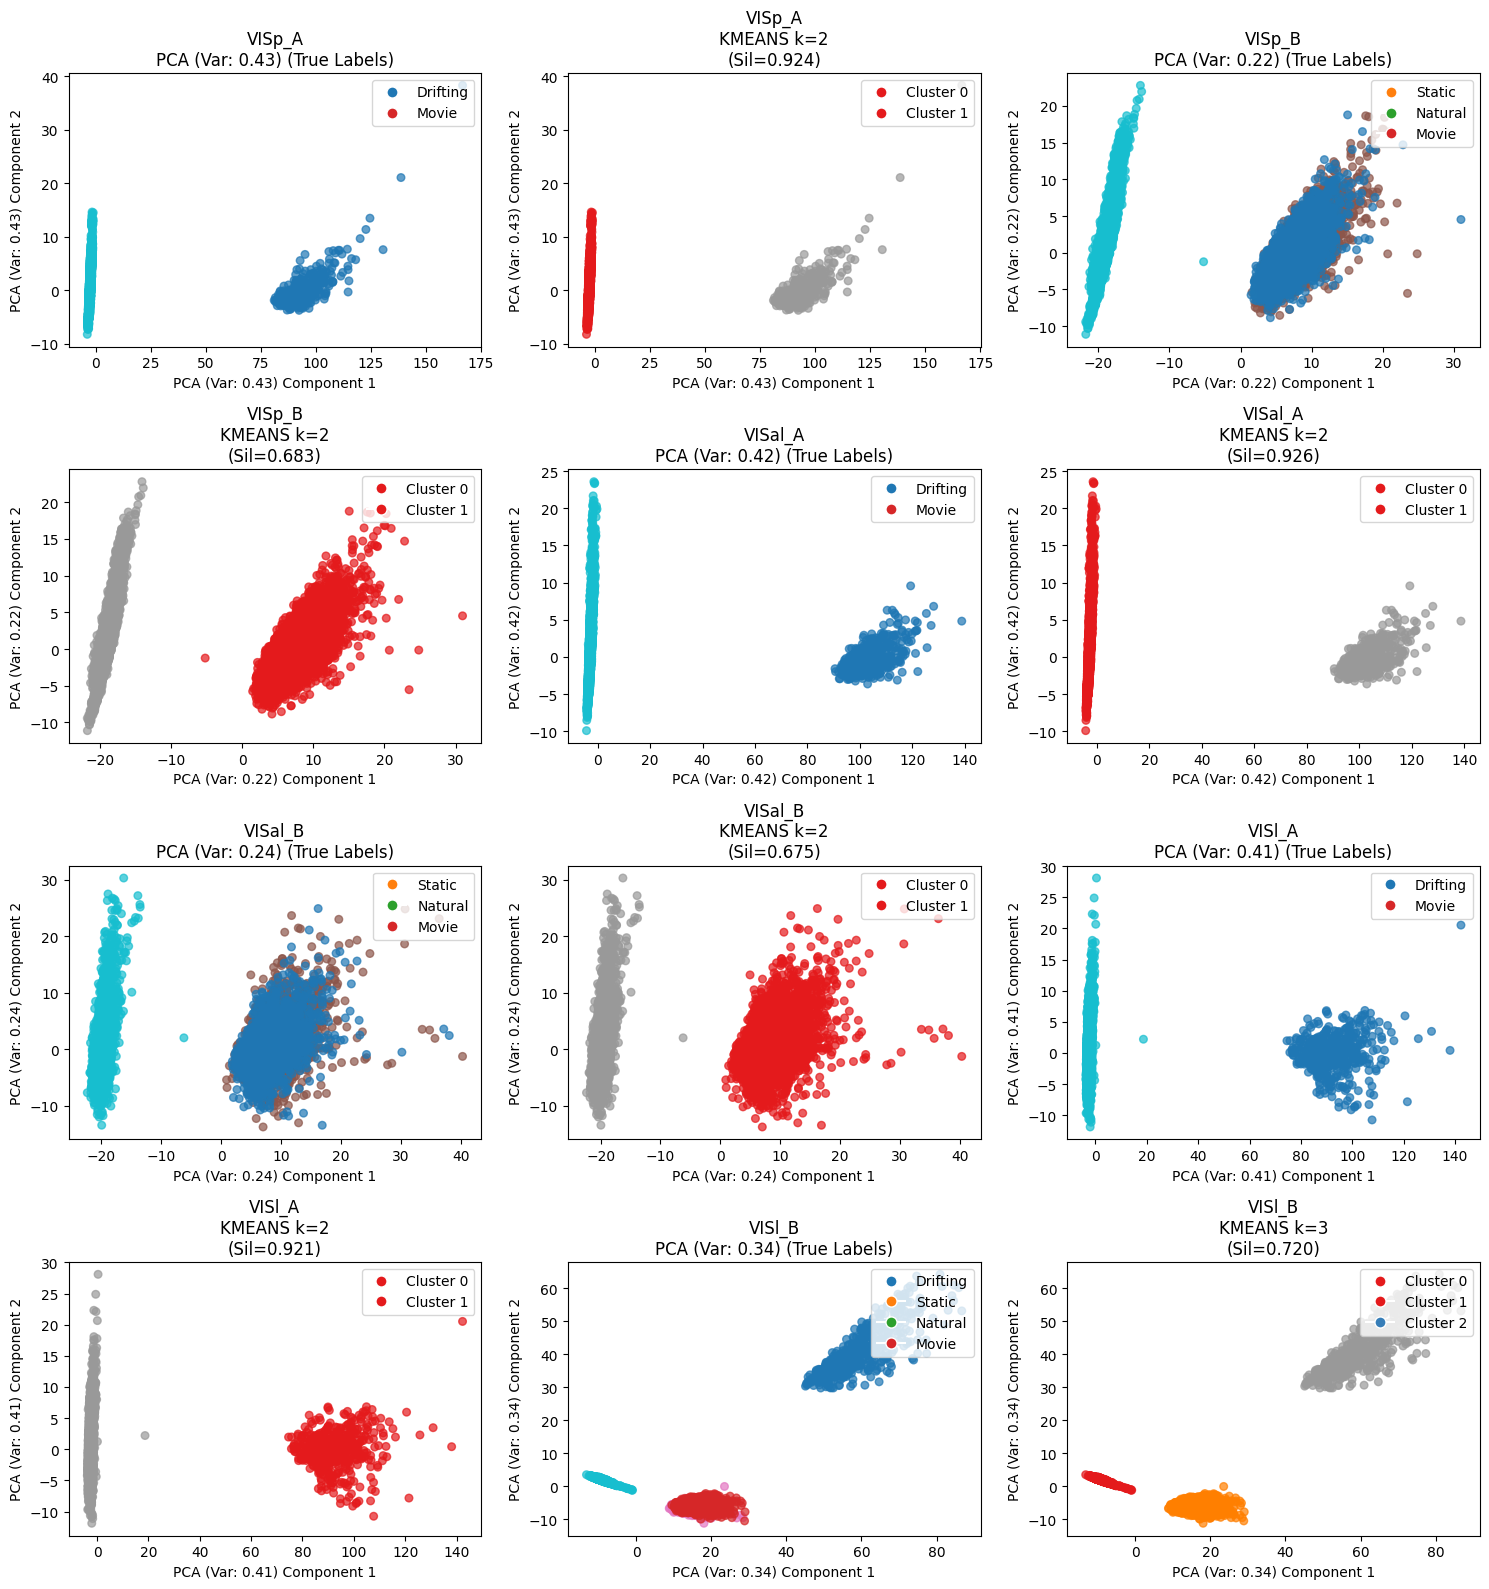

生成聚类性能比较...


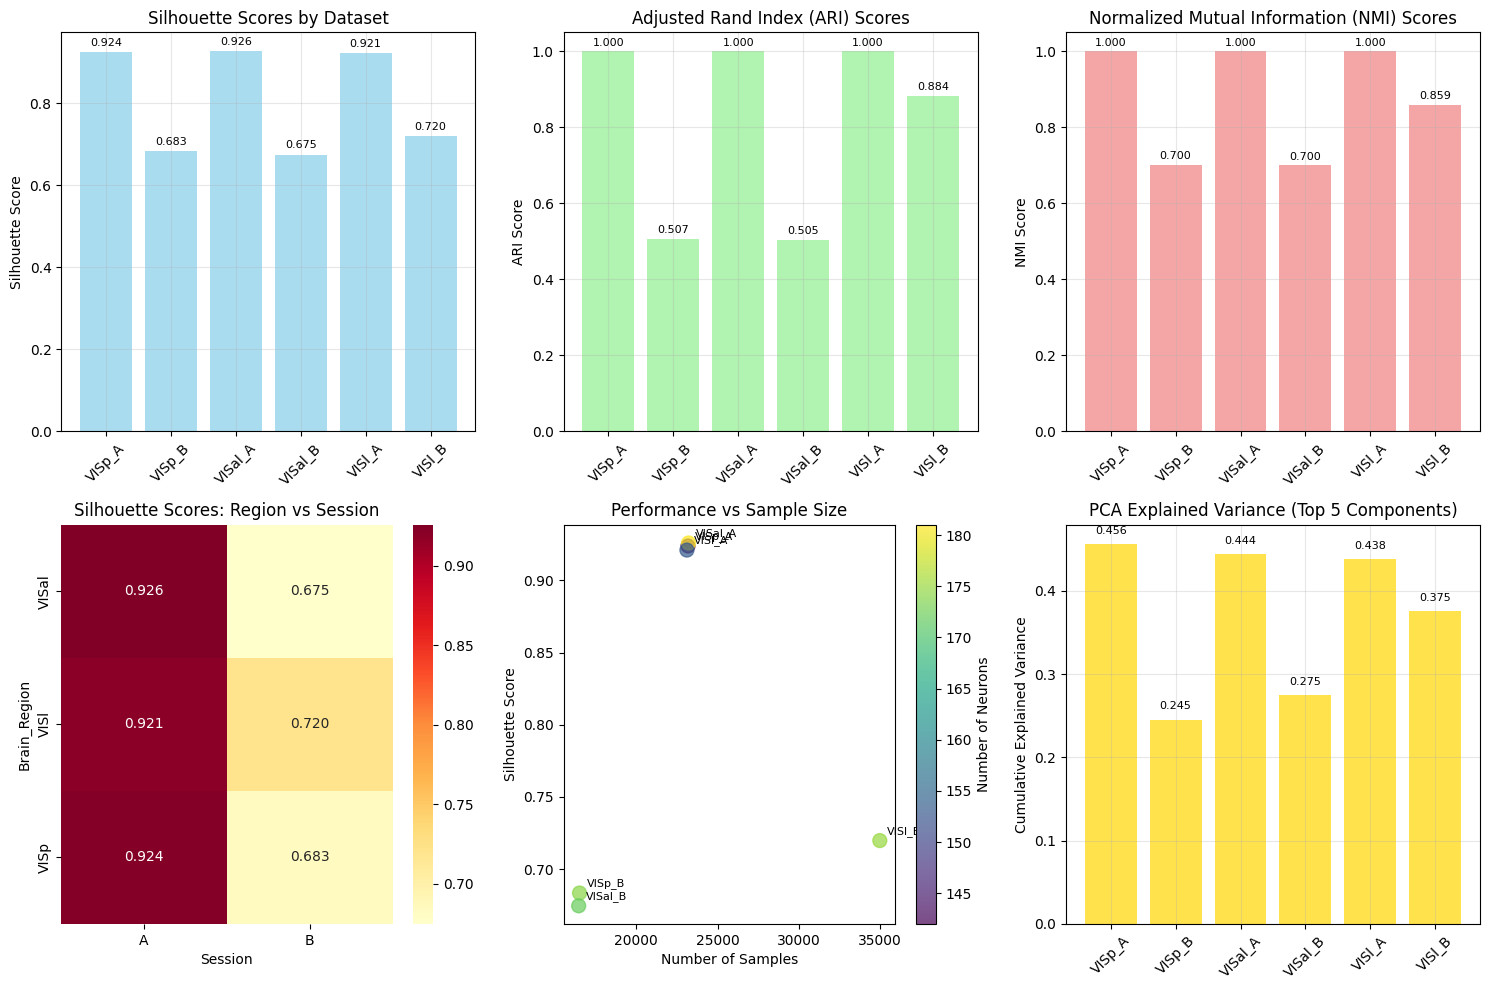

生成比较报告...

无监督分析结果详细报告
Dataset Brain_Region Session  N_Samples  N_Neurons  Best_Silhouette  ARI_Score  NMI_Score Best_Method  Best_N_Clusters  PCA_Var_Top3  PCA_Var_Top5
 VISp_A         VISp       A      23181        142         0.923825   1.000000   1.000000      kmeans                2      0.442514      0.456332
 VISp_B         VISp       B      16501        174         0.683428   0.507324   0.700458      kmeans                2      0.229943      0.245264
VISal_A        VISal       A      23217        181         0.925909   1.000000   1.000000      kmeans                2      0.429091      0.444325
VISal_B        VISal       B      16447        172         0.674569   0.504861   0.699671      kmeans                2      0.256831      0.274751
 VISl_A         VISl       A      23115        153         0.920985   1.000000   1.000000      kmeans                2      0.417738      0.438270
 VISl_B         VISl       B      34998        175         0.719757   0.883806   0.859315      

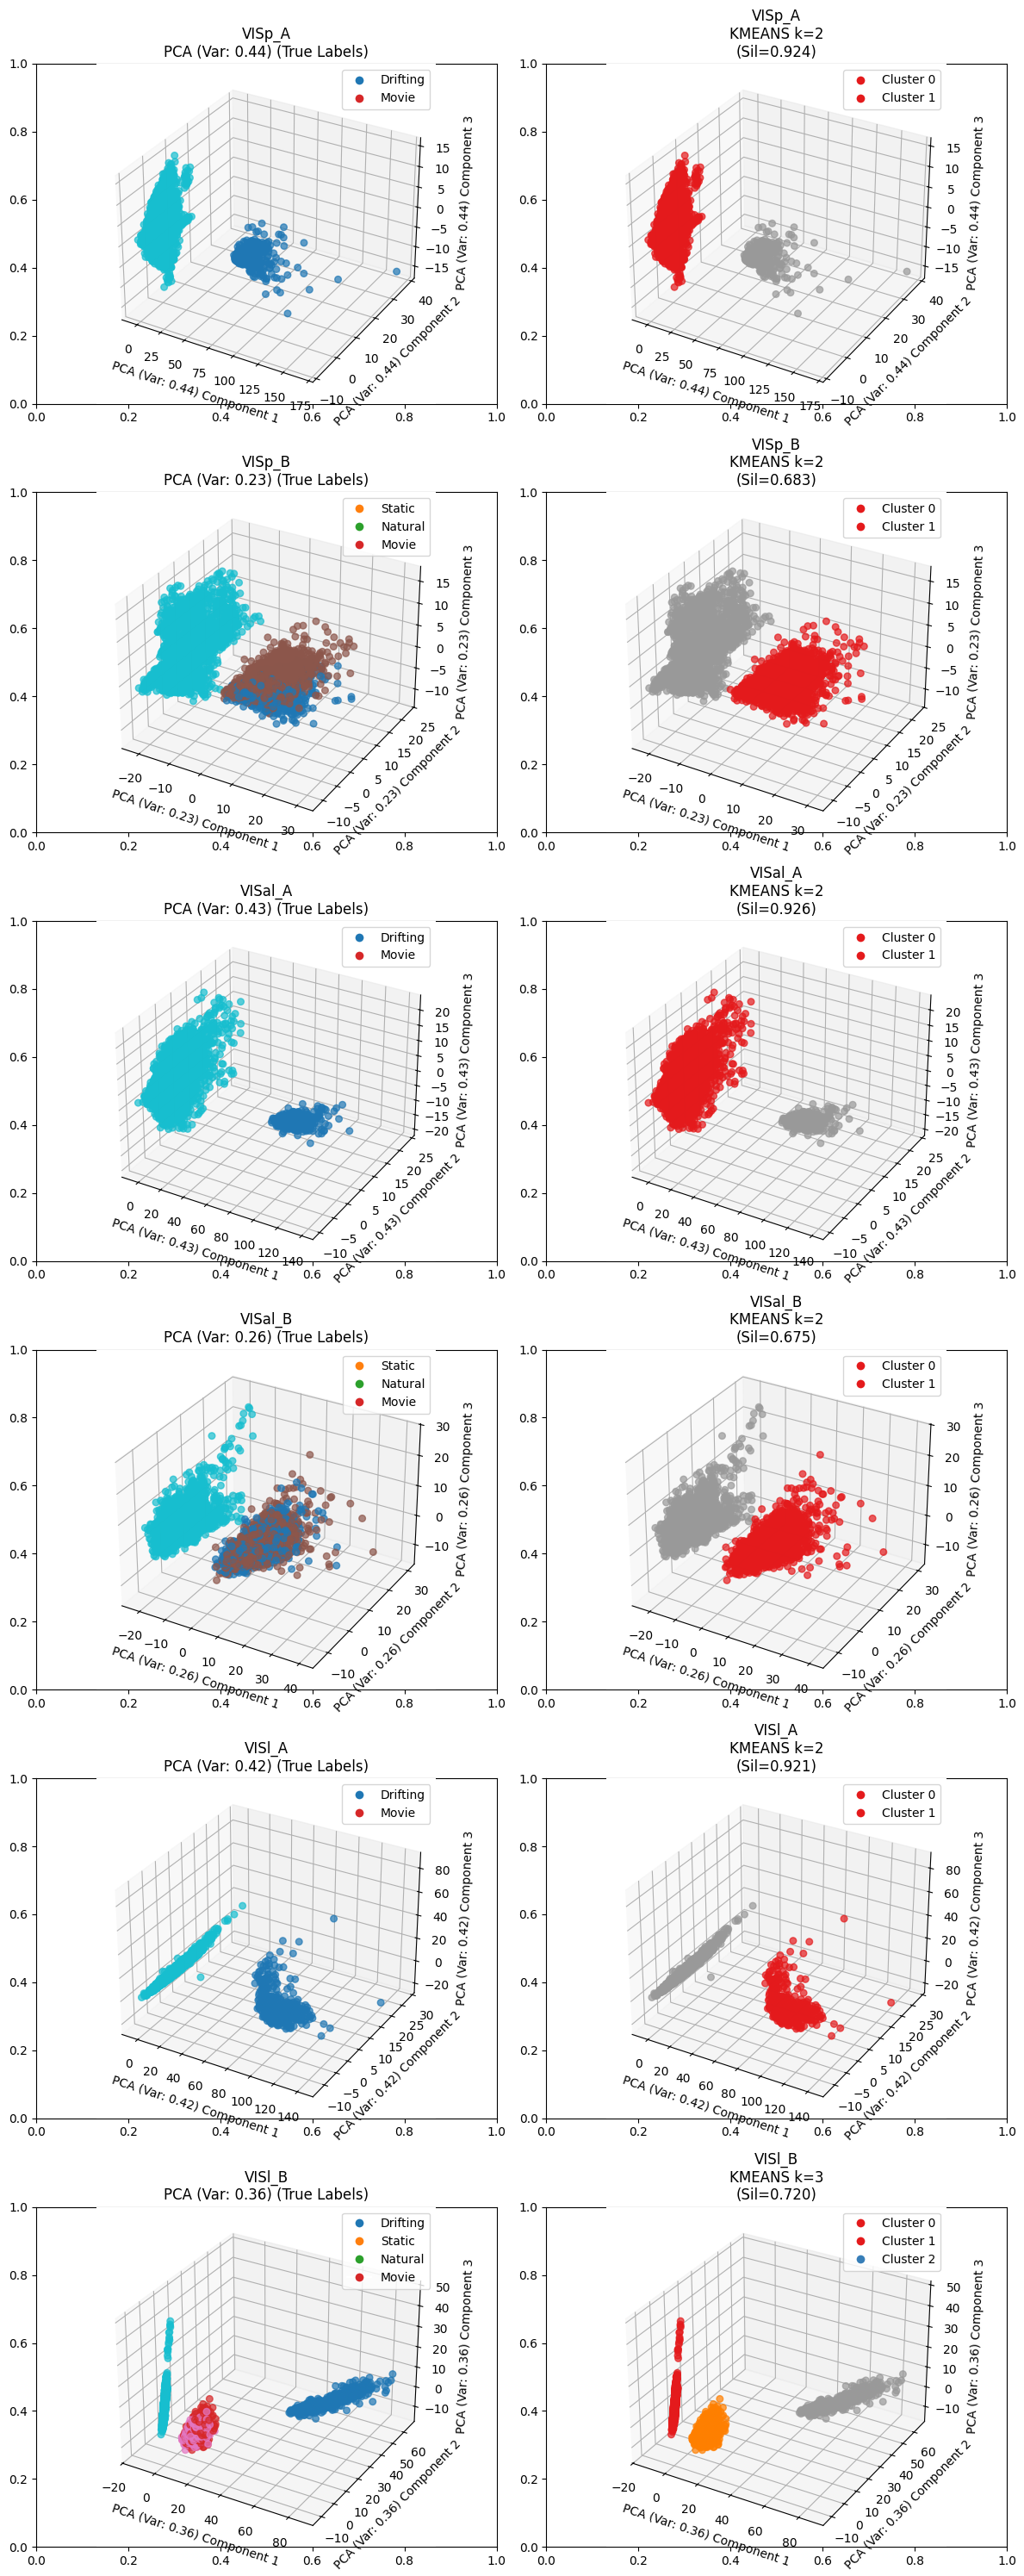

可视化完成！


In [9]:
# 执行可视化分析
print("\n开始可视化分析...")

# 1. 使用PCA进行可视化（2D）
print("生成PCA 2D可视化...")
reduction_data_2d = plot_unsupervised_results(analyzer, 
                                            reduction_methods=['pca'], 
                                            n_components=2,
                                            figsize_per_dataset=(5, 4),
                                            cols_per_row=3)

# 2. 生成聚类性能比较图
print("生成聚类性能比较...")
plot_clustering_comparison(analyzer)

# 3. 生成详细报告
print("生成比较报告...")
comparison_df = generate_comparison_report(analyzer)

# 4. 如果要使用3D PCA可视化
print("生成PCA 3D可视化...")
reduction_data_3d = plot_unsupervised_results(analyzer, 
                                            reduction_methods=['pca'], 
                                            n_components=3,
                                            figsize_per_dataset=(6, 5),
                                            cols_per_row=2)

print("可视化完成！")

In [ ]:
# 将来要使用t-SNE或UMAP时：
# # 使用t-SNE
# plot_unsupervised_results(analyzer, reduction_methods=['pca', 'tsne'], n_components=2)

# # 使用UMAP（需要先安装：pip install umap-learn）
# plot_unsupervised_results(analyzer, reduction_methods=['pca', 'umap'], n_components=2)

# # 同时比较多种方法
# plot_unsupervised_results(analyzer, reduction_methods=['pca', 'tsne', 'umap'], n_components=2)